In [1]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '191ad9a9-06a5-416b-8886-3dbd99bbb57c'
resource_group = 'ADL_Project'
workspace_name = 'Medical_Imaging'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Image_data_arrays')
image_data = dataset.download(target_path='.', overwrite=True)  # setting overwrite = True to load up data again if not loaded 

In [2]:
# Storing all required paths for further use
train_test_valid_x_image_data = image_data[0]
train_test_valid_y_labels_data = image_data[1]

In [3]:
# Importing required libraries

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import warnings
import re
import os


In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

### Helper Functions

In [5]:
def get_cwd_files(path):

  ignore_files = [".gitkeep", ".gitignore"]
  path_files = os.listdir(path)
  path_files = [file for file in path_files if file not in ignore_files]

  return path_files

In [6]:
def get_image_data(image_data_process_directory, image_resize_value):

  # Classes for our prediction
  classification_classes = ["Healthy_bones", "Fractured_bones", "Bones_beyond_repair"]
  classification_classes_dict = {1:"Healthy_bones", 2:"Fractured_bones", 3:"Bones_beyond_repair"}
  # Set Image size
  img_size = image_resize_value

  #flag_counter = 0
  # Processing image to array
  #data = []
  image_data = []
  label_data = []
  for each_class in classification_classes:
    #flag_counter = 0
    class_category_number = classification_classes.index(each_class)
    bone_class_img_path = os.path.join(image_data_process_directory, each_class)
    #print(bone_class_img_path)
    bone_images = get_cwd_files(bone_class_img_path)
    for bone_image in bone_images:
      
      '''
      if flag_counter == 50:
        break
      flag_counter += 1'''

      bone_image_path = os.path.join(bone_class_img_path, bone_image)
      #print(bone_image_path)
      try:
        x_ray_image = load_img(bone_image_path, target_size=(img_size, img_size))
        x_ray_image = img_to_array(x_ray_image)
        image_data.append(x_ray_image)
        label_data.append(class_category_number)
        #print(x_ray_image.shape)
        #data.append([x_ray_image, class_category_number])
      except:
        print("Some error occured in fetching data!")

  
  #data = np.array(data)
  image_data = np.array(image_data)
  label_data = np.array(label_data) 
  
  return image_data, label_data  


### Main Program

Pre processing images to arrays and storing them is done only for the first run and for subsequent runs load the saved array images files for further work to reduce time.

In [7]:
# Processing train data images
#train_test_valid_x, train_test_valid_y = get_image_data(dataset_cwd, image_resize_value = 224)

### Storing image array data of images processed  

In [8]:
# Storing Train_test_valid image array values

# For train_test_valid_x compressed values
#np.savez_compressed("train_test_valid_x_images_compressed_data_array_224", train_test_valid_array = train_test_valid_x)

# For train_test_valid_y compressed values
#np.save("train_test_valid_y_labels_compressed_array_224", train_test_valid_y)

### Loading Image arrays from saved files 

In [9]:
# Loading Train image compressed array values

# For train_x values
model_train_test_valid_x = np.load(train_test_valid_x_image_data)["train_test_valid_array"]

# For train_y values
model_train_test_valid_y = np.load(train_test_valid_y_labels_data)

In [10]:
# Creating train and test dataset
train_valid_x, model_test_x, train_valid_y, model_test_y = train_test_split(model_train_test_valid_x, model_train_test_valid_y, random_state = 42, stratify = model_train_test_valid_y, test_size = 0.10)

In [11]:
# Creating train and test dataset
model_train_x, model_valid_x, model_train_y, model_valid_y = train_test_split(train_valid_x, train_valid_y, random_state = 42, stratify = train_valid_y, test_size = 0.15)

In [12]:
# Removing specific variables from runtime to save RAM
del model_train_test_valid_x, model_train_test_valid_y, train_valid_x, train_valid_y

In [13]:
# Normalizing values
model_train_x, model_train_y = model_train_x/255, model_train_y
model_test_x, model_test_y = model_test_x/255, model_test_y
model_valid_x, model_valid_y = model_valid_x/255, model_valid_y

### Data Visualization 

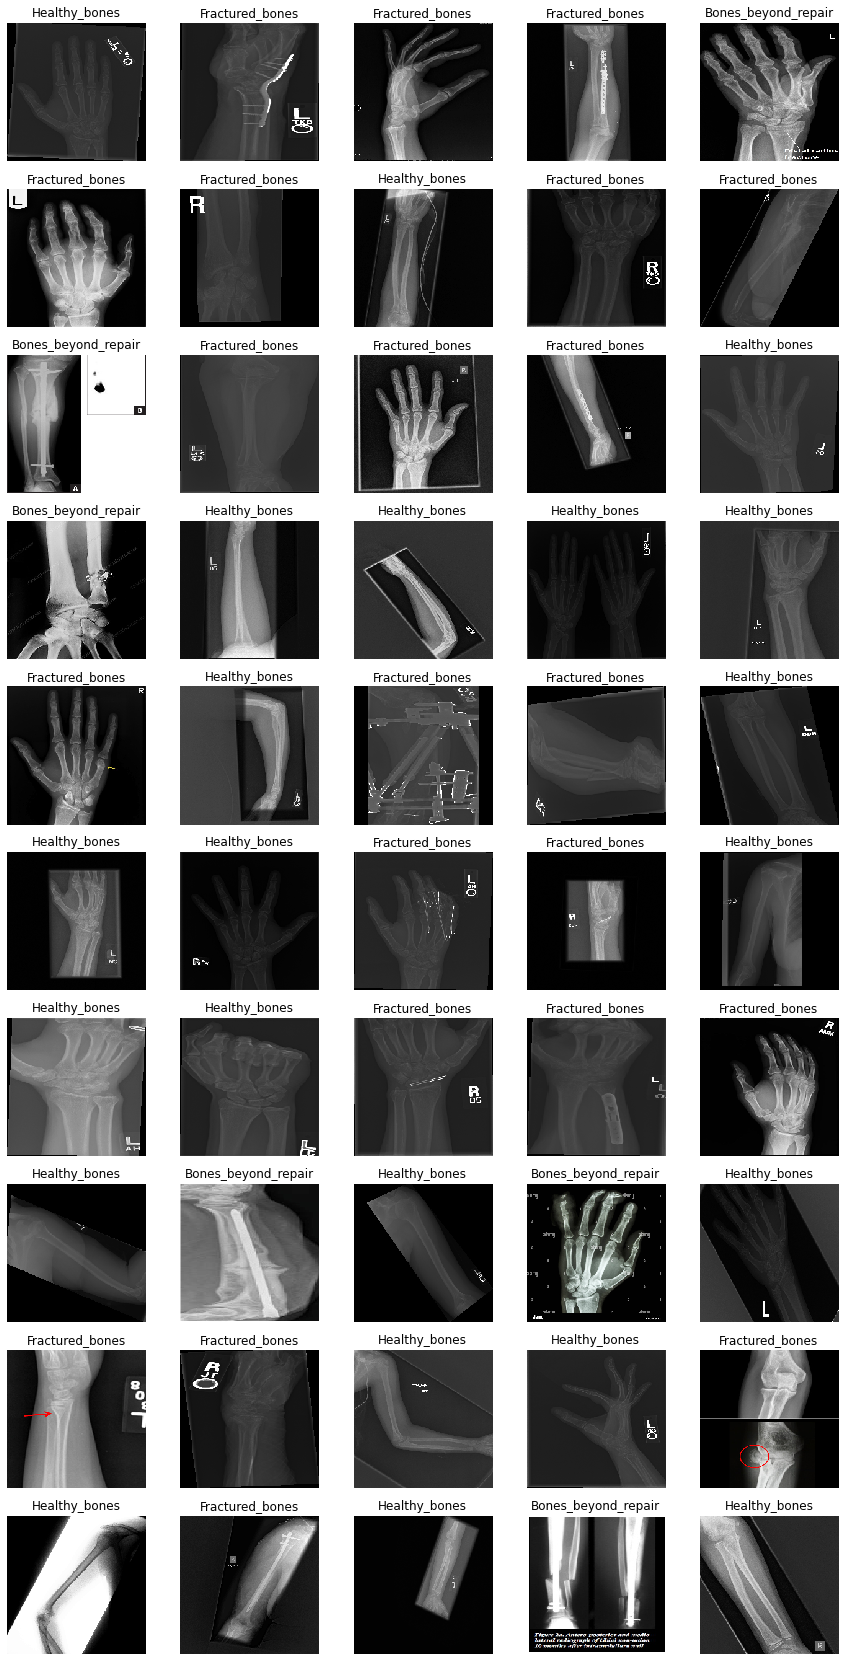

In [14]:
## visualizing some training data
sample_training_data = list(model_train_x[0:50])
sample_training_label = list(model_train_y[0:50])
label_mapping = {0:"Healthy_bones", 1:"Fractured_bones", 2:"Bones_beyond_repair"}

plt.figure(figsize=(15,30))
for i in range(50):
  plt.subplot(10, 5, i + 1)
  img_pil = array_to_img(sample_training_data[i])
  plt.imshow(img_pil, interpolation='nearest')
  plt.title(label_mapping[sample_training_label[i]])
  plt.axis("off")

### Hyperparameters for Data Augmentation 

In [15]:
# Hyperparameters for Imagedatagenerator
model_shear_range = 0.2           # Image angular deformation range
model_zoom_range = 0.2            # Image zoom in/out range
model_brightness_range = [0.9,1.2]    # Brightness change range (0.9 to 1.2)
model_rotation_range = 30         # Angular change range
model_width_shift_range = 0.2     # Horizontal shift range
model_height_shift_range = 0.2    # Vertical shift range

### Data Augmentation Initialization 

In [16]:
# Image generator for training images
train_gen = ImageDataGenerator(
    rotation_range = model_rotation_range,
    #brightness_range = model_brightness_range,
    #width_shift_range = model_width_shift_range,
    #height_shift_range = model_height_shift_range,
    #zoom_range = model_zoom_range,
    #shear_range = model_shear_range,
    horizontal_flip = True,
    vertical_flip=True,
    #fill_mode = "constant",
    #cval = 0.0  # fill with black color for any blank spaces present after image shift
)

# Image generator fo validation images
valid_gen = ImageDataGenerator()  # No parameters

### Data Augmentation 

In [17]:
# Fitting image generator models to datasets 
train_gen.fit(model_train_x)
valid_gen.fit(model_valid_x)

# Creating iter variables for model compile flow
train_iter = train_gen.flow(model_train_x, model_train_y, batch_size = 32)
valid_iter = valid_gen.flow(model_valid_x, model_valid_y, batch_size = 8, shuffle = False)

### Hyperparameters for model building 

In [18]:
# Model hyperparameters
model_accuracy = ["acc", "mse"]

# When using all 3 classes (healthy bones, fractured bones and bones beyond repair), then this categorical cross entropy loss
# Using Sparse categorical instead of just categorical as the classes here are considered to be mutually exclusive and hence sparse categorical
# If the sample could have multiple classes or labels (not completely mutually exclusive), then use categorical.
model_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Now as we are working with 2 class currently (healthy bones and fractured bones) we will use binary crossentrophy loss
#model_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Model checkpoints directory as per version of models created (This is version 1)
#model_checkpoints_dir = os.path.join(model_checkpoints_cwd, "v1")

model_lr = 0.000001  # 0.000001
model_l2_regularizer_lambda = 0.000001
model_optimizer = Adam(learning_rate = model_lr)
#model_optimizer = RMSprop(learning_rate = model_lr)
model_epochs = 500
model_pooling = "avg"
model_callbacks = [
                #ModelCheckpoint(model_checkpoints_dir, monitor = "val_loss", save_best_only=True, mode="min",options=None),
                EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=8,verbose=1, mode="min",restore_best_weights=True),
                ReduceLROnPlateau(monitor="val_loss",min_delta=1e-4, factor=0.1, patience=3, verbose=1, min_lr=0.0001,mode="min")                
                ]

# After an intial run, we understood as the classes are heavily imbalanced (maybe due to imbalanced dataset or lack of features from the other unpredicted class),
# We use assigning class weights option to let our model train from all classes uniquely, later we will also try to increase our dataset for the better classification
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(model_train_y), y = model_train_y)
model_class_weights = dict(zip(np.unique(model_train_y), weights))

### Model Building 

In [19]:
# Function for getting pre trained model
def get_pre_trained_model_Xception():

  try:
    # Importing model excluding the fully connected layer at the top
    model = Xception(include_top=False, weights = 'imagenet', input_shape=(224, 224, 3), pooling = model_pooling)
  
  except:
    print("Pre-trained model Initialization failed !!")

  # Freezing the pretrained model weights so that they wont be updated during back propagation
  for layer in model.layers:
    layer.trainable = False

  last_output = model.layers[-1].output

  return model, last_output

In [20]:
# Model Architecture

cnn_model, last_output = get_pre_trained_model_Xception()

flattened_last_layer_output = Flatten()(last_output)
dense_layer_1 = Dense(1024, kernel_initializer = 'he_uniform', activation='relu')(flattened_last_layer_output)
dropout_output_1 = Dropout(0.4)(dense_layer_1)
dense_layer_2 = Dense(512, kernel_initializer = 'he_uniform', activation='relu')(dropout_output_1)
dropout_output_2 = Dropout(0.4)(dense_layer_2)

final_layer = Dense(3, activation="softmax")(dropout_output_2)
cnn_model = Model(cnn_model.input, final_layer)

cnn_model.compile(optimizer = model_optimizer, loss = model_loss, metrics = model_accuracy)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [21]:
# Model Plot
plot_model(cnn_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [22]:
# Model fit
history = cnn_model.fit(train_iter, validation_data=valid_iter, steps_per_epoch=len(model_train_x)/32, epochs=model_epochs, callbacks=model_callbacks)

Epoch 1/500
88/88 [==============================] - 34s 336ms/step - loss: 1.1744 - acc: 0.3990 - mse: 0.8421 - val_loss: 1.0780 - val_acc: 0.4280 - val_mse: 0.8234 - lr: 1.0000e-06
Epoch 2/500
88/88 [==============================] - 28s 316ms/step - loss: 1.1624 - acc: 0.3965 - mse: 0.8411 - val_loss: 1.0633 - val_acc: 0.4060 - val_mse: 0.8217 - lr: 1.0000e-06
Epoch 3/500
88/88 [==============================] - 28s 316ms/step - loss: 1.1563 - acc: 0.4008 - mse: 0.8410 - val_loss: 1.0516 - val_acc: 0.4200 - val_mse: 0.8210 - lr: 1.0000e-06
Epoch 4/500
88/88 [==============================] - 28s 316ms/step - loss: 1.1545 - acc: 0.3926 - mse: 0.8401 - val_loss: 1.0416 - val_acc: 0.4260 - val_mse: 0.8206 - lr: 1.0000e-06
Epoch 5/500
88/88 [==============================] - 28s 315ms/step - loss: 1.1212 - acc: 0.4146 - mse: 0.8397 - val_loss: 1.0327 - val_acc: 0.4340 - val_mse: 0.8209 - lr: 1.0000e-06
Epoch 6/500
88/88 [==============================] - 28s 317ms/step - loss: 1.1228 - 

In [29]:
# Save model
keras.models.save_model(cnn_model, "Transfer_learning_model_v3.h5", save_format="h5")

<Figure size 432x288 with 0 Axes>

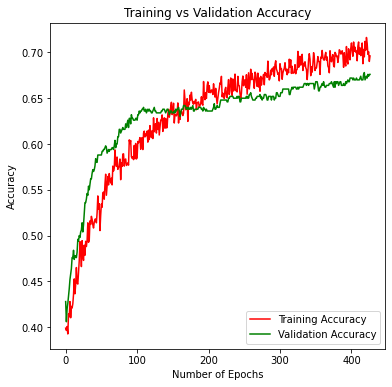

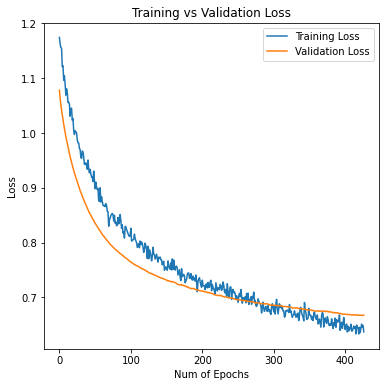

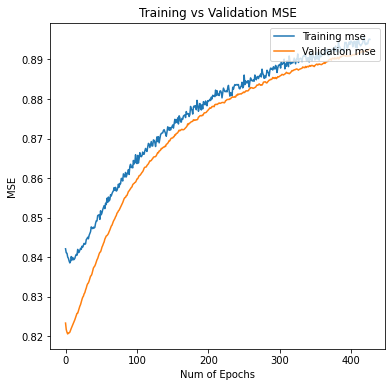

In [24]:
# Model History Plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mse']
val_mse = history.history['val_mse']
epochs_range = range(len(history.history['loss']))

plt.figure(0)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'g', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.figure(1)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.figure(2)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, mse, label='Training mse')
plt.plot(epochs_range, val_mse, label='Validation mse')
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.legend(loc='upper right')
plt.title('Training vs Validation MSE')

plt.show()

### Prediction Stats 

In [25]:
# Finding Prediction Error

# Since for now we are dealing with a binary classifciation problem (healthy bones and fractured bones), we use the following method
# Later when we continue working with all 3 classes (healthy bones, fractured bones and bones beyond repair), we will change the below maths accordingly
model_test_prediction_labels = cnn_model.predict(model_test_x)
model_test_prediction_list = []

for label_prediction in model_test_prediction_labels:
    model_test_prediction_list.append(np.argmax(label_prediction))


prediction_error = np.sum(np.not_equal(model_test_prediction_list, list(model_test_y))) / model_test_y.shape[0]
print(f"The prediction error for the model is {prediction_error}")


The prediction error for the model is 0.3108108108108108


The model prediction error should be close to zero. The above value will show how much the model needs more tuning and optimization in order to have prediction error closer to zero.

In [26]:
# Model testing stats
model_evaluation = cnn_model.evaluate(model_test_x, model_test_y, batch_size=8)
print(dict(zip(cnn_model.metrics_names, model_evaluation)))

47/47 [==============================] - 3s 56ms/step - loss: 0.6395 - acc: 0.6892 - mse: 0.8922
{'loss': 0.6395161151885986, 'acc': 0.6891891956329346, 'mse': 0.8922259211540222}


### Metric Stats 

In [27]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Classification Report: 
              precision    recall  f1-score   support

           0       0.66      0.88      0.76       150
           1       0.64      0.48      0.55       141
           2       0.85      0.70      0.76        79

    accuracy                           0.69       370
   macro avg       0.72      0.69      0.69       370
weighted avg       0.69      0.69      0.68       370

Confusion Matrix: 


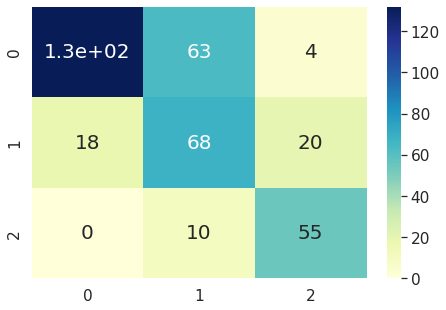

In [28]:
# Classification Report:
print('Classification Report: ')
print(classification_report(list(model_test_y), model_test_prediction_list, target_names=["0","1", "2"]))

# Confusion Matrix
import seaborn
print('Confusion Matrix: ')
cm = confusion_matrix(model_test_prediction_list, list(model_test_y))
plt.figure(figsize = (7.5,5))
seaborn.set(font_scale=1.4) # for label size
seaborn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()